In [1]:
#このファイルで使うモジュールのimport
import numpy as np
import matplotlib.pyplot as plt
import pprint
import hashlib
from statistics import mean
import tqdm
import math
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import time
import random

trans = torchvision.transforms.ToTensor()

In [2]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch

import pathlib
import sys
from pathlib import Path
current_dir = Path().resolve().parent
sys.path.append(str(current_dir))
sys.path.append("/work/ml_errorinjection/")
sys.path.append("/work/ml_errorinjection/modules/")
sys.path.append("/work/ml_errorinjection/script/")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
print('device: ', device)

device:  cuda:0


In [4]:
# オセロの状態を表すクラス(構造体)
# 8x8の盤面を持ち、各マスには黒か白か空かのいずれかが入る
# 盤面の状態を配列で表現する
class Board():
    # 8x8の配列を初期化する
    def __init__(self):
        self.board = [[0 for i in range(8)] for j in range(8)]
        self.board[3][3] = 1    # 白(◯)
        self.board[4][4] = 1    # 白
        self.board[3][4] = -1    # 黒(×)
        self.board[4][3] = -1    # 黒
        self.player = -1         # 黒が先手
    # 盤面の配列を取得する
    def getBoard(self):
        return self.board
    # 盤面の配列をベクトルとして取得する
    def getBoardVec(self):
        return np.array(self.board).reshape(64).tolist()
    # 盤面の状態を表示する
    def show(self):
        for row in self.board:
            print("|", end="")
            for cell in row:
                if cell == 0:
                    print(" ", end="")  # end="" で改行しない
                elif cell == 1:
                    print("o", end="")
                elif cell == -1:
                    print("x", end="")
            print("|")                     # 一行表示して改行
        print("player: o") if self.player == 1 else print("player: x")
    # ファイルに盤面の状態を書き込む
    def fshow(self, filename):
        with open(filename, "a") as f:
            for row in self.board:
                f.write("|")
                for cell in row:
                    if cell == 0:
                        f.write(" ")
                    elif cell == 1:
                        f.write("o")
                    elif cell == -1:
                        f.write("x")
                    # f.write(str(cell))
                f.write("|\n")
            if self.player == 1:
                f.write("player: o")
            else:
                f.write("player: x")
    # 置く場所が盤面上にあるか判定する
    def outofBoard(self, x, y):
        return x < 0 or x >= 8 or y < 0 or y >= 8
    # (x, y)に石を置くとき、(dx, dy)方向にひっくり返す石があるか判定する
    def canPutDir(self, x, y, dx, dy):
        i = 1
        if self.outofBoard(x + dx, y + dy):
            return False
        else:
            while self.board[y + dy * i][x + dx * i] == -(self.player):    # 相手の石が続く限り
                i += 1
                if self.outofBoard(x + dx * i, y + dy * i):                 # 盤面外に出たら
                    return False
                elif self.board[y + dy * i][x + dx * i] == 0:               # 石がない場所があれば
                    return False
                elif self.board[y + dy * i][x + dx * i] == self.player:     # 自分の石で挟めるなら
                    return True
    # (x, y)に石を置けるか判定する
    def canPut(self, x, y):
        if not self.outofBoard(x,y) and self.board[y][x] != 0:                                           # すでに石が置かれている
            return False
        # 周囲8方向を調べる; 1方向でもひっくり返せるなら置ける
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if dx == 0 and dy == 0:
                    continue
                if self.canPutDir(x, y, dx, dy):                             # (dx, dy)方向にひっくり返せる石がある
                    return True
        return False
    # (x, y)に石を置いたときの盤面クラスを返す
    def put(self, x, y):
        newBoard = Board()
        newBoard.board = [row[:] for row in self.board] # 盤面をコピー
        newBoard.player = -self.player   # プレイヤーを交代
        newBoard.board[y][x] = self.player  # 石を置く
        # ひっくり返せる石を全てひっくり返す
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if dx == 0 and dy == 0:
                    continue
                if self.canPutDir(x, y, dx, dy):
                    i = 1
                    while newBoard.board[y + dy * i][x + dx * i] == -self.player:
                        newBoard.board[y + dy * i][x + dx * i] = self.player    # 石をひっくり返す
                        i += 1
        return newBoard
    # 石を置ける場所があるか判定する
    def canPlay(self):
        for y in range(8):
            for x in range(8):
                if self.canPut(x, y):
                    return True
        return False
    # 石を置ける場所と置いた場合の盤面クラスを辞書型で返す
    def choices(self):          # 動的計画法において、for choice in board.choices(): で呼び出す
        choices = {}
        for y in range(8):
            for x in range(8):
                if self.canPut(x, y):
                    choices[(x, y)] = self.put(x, y)
        return choices
    # 石を置ける場所がなく場合にプレイヤーを交代するか判定し、交代する (交代する場合は新たな盤面を返す)
    def passPlayer(self):   # Board.passPlayer()で呼び出す
        if not self.canPlay():
            # 新たな盤面を作成し、プレイヤーを交代する
            newBoard = Board()
            newBoard.board = [row[:] for row in self.board] # 盤面をコピー
            newBoard.player = -self.player
            return newBoard
        else:
            return self
    # 盤面が等しいか判定する
    def isEq(self, other):
        return self.board == other.board and self.player == other.player
    # 盤面を比較し、打った手を返す
    def diff(self, other):
        for y in range(8):
            for x in range(8):
                if self.board[y][x] != other.board[y][x]:
                    return (x, y)
        return None
    # 勝負がついたか判定する
    def isEnd(self):
        if not self.canPlay() and not self.passPlayer().canPlay():
            # print("Game Over")
            # self.winner()
            return True
        else:
            return False
    # 石の数を数え、勝敗を判定する
    def counter(self, num):
        tot = 0
        for row in self.board:
            for cell in row:
                if cell == num:
                    tot += 1
        return tot
    # 勝者を返す
    def winner(self):
        if not self.isEnd():
            return
        # print("Game Over")
        black = self.counter(-1)
        white = self.counter(1)
        if black > white:
            # print("Black(×) wins!")
            return -1
        elif black < white:
            # print("White(◯) wins!")
            return 1
        else:
            # print("Draw")
            return 0

In [5]:
# Monte-Carlo Tree のノードを表すクラス
class MCTSNode:
    def __init__(self, board, x=0, y=0):
        self.board = board          # Boardクラス
        self.parent = None          # 親ノード
        self.children = []          # 子ノード
        self.visits = 0             # ノードを訪れた回数
        self.score = 0              # ノードの評価値
        self.x = x                  # 石を置いた場所
        self.y = y
    # ノードの展開(子ノードを追加)
    def expand(self):
        if self.board.isEnd():          # ゲーム終了時は展開しない
            return
        elif len(self.children) > 0:    # 既に展開済みの場合は展開しない
            return
        else:
            choices = self.board.choices()              # 石を置ける場所と置いた場合の盤面クラスを取得(Boardクラスのchoicesメソッド)
            for choice, board in choices.items():       # 石を置ける場所全てについて、子ノードに追加
                x, y = choice
                node = MCTSNode(board, x, y)
                node.parent = self
                self.children.append(node)
    # 子ノードの選択確率を計算し、石を置いた場所にその確率を当てはめた二次元配列を返す
    def copy(self):
        node = MCTSNode(self.board, self.x, self.y)
        node.parent = self.parent
        node.visits = self.visits
        node.score = self.score
        return node
    
    def probabilities(self, flag):
        probs = [[0 for i in range(8)] for j in range(8)]
        choices = self.board.choices()
        for child in self.children:
            board = child.board
            x, y = child.x, child.y
            probs[y][x] = child.visits/self.visits
        if flag==True:
            return np.array(probs).reshape(64).tolist()
        else:
            return probs

In [6]:
#mctsNodeで、choiceを選択することの評価値(行動価値関数と探索項の和)を返す
def alpha_zero_score(mctsNode,key,child, mcTree, net,p, flag=True):
    # ハイパーパラメータ
    c_base = 200
    c_init = 1.25
    # 行動価値関数の値を計算
    inx = process(child.board.getBoard(), child.board.player)
    p0, v = net.forward(inx)                   # ニューラルネットワークに盤面を入力し、方策と価値を取得
    #print(p0,v)
    v = v.item()                                        # tensorを数値に変換
    x, y = key
    p = p[0][8*y+x]
    p = p.item()
    N = mctsNode.visits                                 # mctsNodeを訪れた回数
    # childNode = mcTree.move_cop(key)                    # keyの手を打ったときのノードを取得
    Nc = child.visits                               # mctsNodeからchoiceを選択した回数
    C = c_init + np.log((N + c_base + 1) / c_base)      # ノードの訪問回数で決まる係数                                    # tensorを数値に変換
    exploration = C * np.sqrt(N) / (1 + Nc) * p          # 探索項
    if flag:
        # ノードの評価値と探索項の和を返す
        return v + exploration
    else:
        return v

In [7]:
def process(board, turn, flag = True):
    board = np.array(board)
    mystones = (board == turn).astype(np.float32)
    opponentstones = (board == -turn).astype(np.float32)
    player = np.full((8,8), turn, dtype = np.float32)
    
    out = torch.tensor(np.array([mystones, opponentstones, player]))
    if flag:
        return out.unsqueeze(0)
    else:
        return np.array([mystones, opponentstones, player])

In [8]:
board = [
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,-1,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,-1,0,0,0],
    [0,0,0,0,-1,0,1,0],
    [0,0,0,0,1,0,0,0],
    [0,0,0,0,-1,0,0,0],
    [-1,0,0,0,0,0,0,1]
]
turn = -1
process(board, turn)

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
          [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]],

         [[-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1.],
        

In [33]:
class MCTree:
    def __init__(self, board):
        self.root = MCTSNode(board)                 # ルートノードを作成
        self.current = self.root                    # 現在のノード
    # ノードの選択(flag=True: 探索を行う, flag=False: 探索を行わない)
    def select(self, net, flag=True):
        node = self.current
        node_max = self.current
        node.expand()
        if len(node.children) == 0:
            return node
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        max_score = -math.inf
        inx = process(node.board.getBoard(), node.board.player)
        p, v = net.forward(inx)
        for child in node.children:
            score = alpha_zero_score(node, (child.x, child.y), child, self, net,p, flag)
            #print("score: ", score)
            if score > max_score:
                #print("True")
                max_score = score
                node_max = child
        #print("ok")
        return node_max
        #return random.choice(node.children)
    # ノードの移動(クラスをコピーせず、現在のノードを変更する)
    def move_cur(self, key):                        # key: 石を置く場所を指定
        # 現在のノードに対して、keyに石を置いた場合の盤面を辞書のキーから検索
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        for choice, board in choices.items():
            if choice == key:                               # keyに石を置いた場合の盤面クラスを子ノードから見つけたら
                for child in self.current.children:
                    if child.board.isEq(board):                # 盤面クラスの一致を確認
                        self.current = child
                        return
    # ノードの移動(クラスをコピーして、現在のノードを変更する)
    def move_cop(self, key):                       # key: 石を置く場所を指定
        # 現在のノードに対して、keyに石を置いた場合の盤面を辞書のキーから検索
        choices = self.current.board.choices()              # 石を置ける場所と置いた場合の盤面を取得
        for choice, board in choices.items():
            if choice == key:                               # keyに石を置いた場合の盤面クラスを子ノードから見つけたら
                for child in self.current.children:
                    if child.board.isEq(board):                # 盤面クラスの一致を確認
                        self.current = child
                        return child

In [10]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, zs): # xs: 盤面の状態が並んだリスト, ys: 方策が並んだリスト, zs: 報酬が並んだリスト
        self.input = xs
        self.target_prob = ys
        self.target_rew = zs
    def __len__(self):
        return len(self.input)
    def __getitem__(self, idx):
        # 盤面の状態を、in_channels=1, 8x8のテンソルに変換
        input = torch.tensor(self.input[idx], dtype = torch.float32)
        #input = input.unsqueeze(0)
        # 方策を、長さ64の一次元テンソルに変換
        target_prob = torch.tensor(self.target_prob[idx], dtype = torch.float32)
        # 報酬を、スカラー値に変換
        target_rew = torch.tensor(self.target_rew[idx], dtype = torch.float32)
        return input, target_prob, target_rew

In [11]:
class Player:
    def __init__(self, net):
        self.net   = net               # ニューラルネットワーク
        self.path = [[]]                # プレイしたノード(MCTSNodeクラス)の履歴
        self.nodes = []                 # ミニバッチ全体で一度でもプレイしたノード(MCTSNodeクラス)のリスト
        self.cursor = 0                 # ミニバッチにおける現在のインデックス
        self.reward = [0,0]             # [黒の報酬、白の報酬](勝利: 1, 引き分け: 0.5, 敗北: 0)
    # 1手プレイする
    def oneplay(self, mctree, flag=True):
        # モンテカルロ木探索
        if len(mctree.current.children)==0:             # 子ノードがない場合は展開
            mctree.current.expand()
            if len(mctree.current.children)==0:         # 打てる手がない場合はパス
                #print("pass")
                #mctree.current.board.show()
                mctree.current = mctree.current.copy()
                mctree.current.board = mctree.current.board.passPlayer()
                self.path[self.cursor].append(mctree.current)
                if mctree.current not in self.nodes:
                    self.nodes.append(mctree.current)
                return mctree
        ans = mctree.select(self.net, flag)  # ノードの選択
        mctree.current = ans    # ノードの選択と現ノードの変更
        self.path[self.cursor].append(mctree.current)                # 選択したノードを記録
        # self.nodesに進んだ先のノードがなければ追加
        if mctree.current not in self.nodes:
            self.nodes.append(mctree.current)
        return mctree
    # 1ゲーム自己対戦する
    def play1game(self, mctree):
        mctree.current = mctree.root
        while not mctree.current.board.isEnd():
            mctree = self.oneplay(mctree)
        board = mctree.current.board
        #board.show()
        if board.winner() == -1:
            self.reward[0] = 1
            self.reward[1] = -1
        elif board.winner() == 1:
            self.reward[0] = -1
            self.reward[1] = 1
        else:
            self.reward[0] = 0
            self.reward[1] = 0
    # プレイしたノードの訪問回数と評価値を更新する
    def backup(self):
        for node in self.path[self.cursor]:                  # プレイしたノード全てについて
            node.visits += 1
            if node.board.player == -1:          # そのノードでプレイしたのが黒の場合
                node.score += self.reward[1]
            else:                               # そのノードでプレイしたのが白の場合
                node.score += self.reward[0]
            # print("score: ", self.reward)
            # print("player:", node.board.player)
            # node.board.show()
            # print("score: ", node.score/node.visits)
    # モンテカルロ・シミュレーションのサンプルサイズ分、1ゲーム自己対戦・backupする
    def play1batch(self, mctree, sample_size):
        for i in range(sample_size):
            print("game", i)
            self.play1game(mctree)
            self.backup()
            if i != sample_size - 1:
                self.cursor += 1
                self.path.append([])
    # self.nodesを、visit回数の降順にソートする
    def sort_nodes(self):
        self.nodes.sort(key=lambda x: x.visits, reverse=True)
    # データをロードする(盤面、手の選択確率、報酬)
    def prepare(self, batch_size):
        # データセットをリストで作成
        xs = []  # 盤面の状態(入力)
        ys = []  # 方策(出力)
        zs = []  # 報酬
        for node in self.nodes:
            # node.board.show()
            # print("score: ", node.score/node.visits)
            x_item = node.board.getBoard()
            # 盤面の状態をndarray型に変換し、全ての要素を+1して、float型に変換
            x_item = process(x_item, node.board.player, False)           # ndarray型に変換
            xs.append(x_item)
            # 教師信号は、mcTreeにおいて、選択されたノードに対する、子ノードの選択確率(ここでは、石を置いた場所に確率を割り当てた64次元のベクトル)
            ys.append(node.probabilities(True))
            # 報酬は、ノードの評価値を割り当てる
            zs.append(node.score/node.visits)
        dataset = MyDataset(xs, ys, zs)   # pytorchに利用可能な形で、データセットを作成
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # データローダーを作成
        return dataloader
    def fshow(self, filename):
        # 盤面をファイルに書き込む
        idx = 0
        for path in self.path:
            if len(path) > 0:
                with open(filename, "a") as f:
                    f.write("---------<< path #")
                    f.write(str(idx))
                    f.write(" >>-----------\n")
                    f.close()
                path[-1].board.fshow(filename)
            idx += 1

In [12]:
import torch.nn.functional as F

class AlphaZeroNet(nn.Module):
    def __init__(self, board_size, action_space):
        super(AlphaZeroNet, self).__init__()

        # Initial convolutional block
        self.initial_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Residual blocks (19 as per AlphaZero)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(5)]
        )

        # Policy head
        self.policy_head = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * board_size * board_size, action_space),
            nn.Softmax(dim=1)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(board_size * board_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.to(device)
        x = self.initial_block(x)

        # Residual blocks
        x = self.res_blocks(x)

        # Policy head
        p = self.policy_head(x)

        # Value head
        v = self.value_head(x)

        return p, v

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        residual = x.to(device)
        out = self.block(x)
        out += residual
        return F.relu(out)

In [13]:
net = AlphaZeroNet(8, 64).to(device)   # AlphaZeroNetを作成

# 対戦の準備
board = Board()             # 盤面を初期化
mctree = MCTree(board)     # モンテカルロ探索木を初期化

# 自己対戦プレイヤーを作成
player = Player(net)
player.play1batch(mctree, 1)  # サンプルサイズ分、自己対戦を行い、学習する

game 0


In [31]:
lossl = []

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ネットワークの初期化
board_size = 8  # オセロの盤面は8x8
alphazeronet = AlphaZeroNet(8, 64).to(device)  # AlphaZeroNetworkを初期化
alphazeronet.load_state_dict(torch.load('bin/alphazero_RandomKiller.pth'))
alphazeronet_optimizer = optim.Adam(alphazeronet.parameters(), lr=0.0002, weight_decay=1e-4)

# 損失関数
policy_criterion = nn.CrossEntropyLoss()  # 方策の損失
value_criterion = nn.MSELoss()            # 状態価値の損失

# エポック数とサンプルサイズ
num_epochs = 10
initial_sample_size = 1000

# ログの設定
# log_filename = "log/train_" + time.strftime("%Y%m%d%H%M") + ".txt"
# with open(log_filename, "w") as f:
#     f.write(time.strftime("%Y/%m/%d %H:%M") + "\n")

time_limit = 36000  # 学習時間の上限（秒）
start_time = time.time()
learn_count = 0

while True:
    # エポックごとの設定
    sample_size = initial_sample_size
    batch_size = 4096#sample_size

    # 学習ループの開始
    if learn_count % 10 == 0:
        print(f"===== learn #{learn_count} =====")

    # 対戦の準備
    board = Board()             # 盤面を初期化
    mctree = MCTree(board)      # モンテカルロ探索木を初期化

    # 自己対戦プレイヤーを作成
    player = Player(alphazeronet)
    player.play1batch(mctree, sample_size)  # サンプルサイズ分、自己対戦を実行
    #player.fshow(log_filename)

    # ミニバッチに分割されたデータを作成
    dataloader = player.prepare(batch_size)

    lossv = 0
    cnt = 0

    # ミニバッチ学習
    for inputs, policy_targets, reward_targets in dataloader:
        # 勾配バッファの初期化
        alphazeronet_optimizer.zero_grad()

        # 順伝播
        policy_output, value_output = alphazeronet.forward(inputs)
        value_output = value_output.view(-1)
        policy_target = policy_targets.to(device)
        reward_target = reward_targets.to(device)
        
        # 損失計算
        policy_loss = policy_criterion(policy_output, policy_target)
        value_loss = value_criterion(value_output, reward_target)
        loss = policy_loss + value_loss
        # print(policy_output, policy_target,value_output, reward_target)
        # print(loss)

        # 逆伝播とパラメータ更新
        loss.backward()
        alphazeronet_optimizer.step()
        lossv += loss.item()
        cnt += 1

    # 学習時間の計測
    lossl.append(lossv/cnt)
    if time.time() - start_time > time_limit:
        break

    learn_count += 1

# モデルの保存
torch.save(alphazeronet.state_dict(), 'bin/dummy.pth')

===== learn #0 =====
game 0
game 1
game 2
game 3
game 4
game 5
game 6
game 7
game 8
game 9
game 10
game 11
game 12
game 13
game 14
game 15
game 16
game 17
game 18
game 19
game 20
game 21
game 22
game 23
game 24
game 25
game 26
game 27
game 28
game 29
game 30
game 31
game 32
game 33
game 34
game 35
game 36
game 37
game 38
game 39
game 40
game 41
game 42
game 43
game 44
game 45
game 46
game 47
game 48
game 49
game 50
game 51
game 52
game 53
game 54
game 55
game 56
game 57
game 58
game 59
game 60
game 61
game 62
game 63
game 64
game 65
game 66
game 67
game 68
game 69
game 70
game 71
game 72
game 73
game 74
game 75
game 76
game 77
game 78
game 79
game 80
game 81
game 82
game 83
game 84
game 85
game 86
game 87
game 88
game 89
game 90
game 91
game 92
game 93
game 94
game 95
game 96
game 97
game 98
game 99
game 100
game 101
game 102
game 103
game 104
game 105
game 106
game 107
game 108
game 109
game 110
game 111
game 112
game 113
game 114
game 115
game 116
game 117
game 118
game 119
game 120


In [44]:
lossl

[4.99689371245248,
 4.974942684173584,
 4.964257512773786,
 4.945569617407663,
 4.91709177834647,
 4.915018660681588,
 4.913541691643851,
 4.889875207628522,
 4.904051099504743,
 4.8811520508357455,
 4.899318388530186,
 4.875411544527326,
 4.851125989641462,
 4.83803619657244,
 4.845060518809727,
 4.856942517416818,
 4.8312549250466486,
 4.81449590410505,
 4.838952711650303,
 4.830285549163818,
 4.825471196855817,
 4.827829088483538,
 4.8314622810908725,
 4.8147760799952914,
 4.797734771456037,
 4.806282111576626,
 4.802850927625384,
 4.8224853447505405,
 4.813099929264614,
 4.800883565630231,
 4.792926413672311,
 4.792161839348929,
 4.791327340262277,
 4.773942129952567,
 4.779893909181867,
 4.783703361238752,
 4.796995197023664,
 4.783066136496408,
 4.7770072392054965,
 4.771895715168545,
 4.805845362799508,
 4.801407132829938,
 4.790128673825945,
 4.759666919708252,
 4.774452209472656,
 4.766184057508196,
 4.782863242285592,
 4.754347290311541,
 4.753748995917184,
 4.752323048455374

In [16]:
def minmax_of_param(model, param):
    for name, i in model.state_dict().items():
        if name == param:
            print(torch.max(i))
            print(torch.min(i))
            break
    return

In [18]:
def visualize_param(ax, model, paramname, title=None, **kwargs):
    # モデル内の特定の層の重みヒストグラムを可視化
    # model: モデル全体
    # layername: 層の名前を指定
    # title: グラフのタイトル
    _plot_flag = False
    for name, param in model.state_dict().items():
        if name == paramname:
            ax.hist(param.detach().cpu().numpy().flatten(), **kwargs)
            #ax.set_yscale('log')
            _plot_flag = True
            break
    ax.set_title(title)
    if not _plot_flag:
        raise NameError('Layername {} not exist. Existing parameters: {}'.format(paramname, list(model.state_dict().keys())))

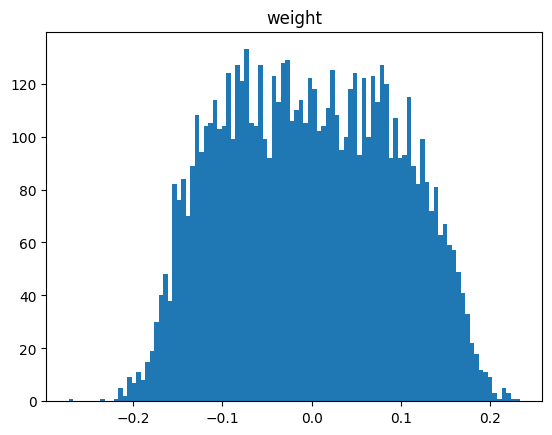

In [ ]:
%reload_ext autoreload
%autoreload 2
import os
SAVE_DIR = 'bin/'
fig, ax = plt.subplots(1,1)
model = AlphaZeroNet(8, 64).to(device)
graph_title = "weight" #ここを変える

model.load_state_dict(torch.load(SAVE_DIR+'alphazero_quantizedmodel.pth'))

#上で作った関数
#minmax_of_param(model, "0.weight")
visualize_param(ax, model, 'initial_block.0.weight', title=graph_title, bins=100, )

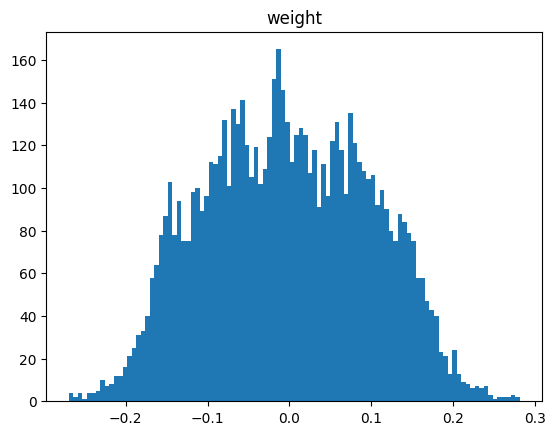

In [ ]:
%reload_ext autoreload
%autoreload 2
import os
SAVE_DIR = 'bin/'
fig, ax = plt.subplots(1,1)
model_quantize = AlphaZeroNet(8, 64).to(device)
graph_title = "weight" #ここを変える

model_quantize.load_state_dict(torch.load(SAVE_DIR+'alphazero_quantizedmodel.pth'))

#上で作った関数
#minmax_of_param(model, "0.weight")
visualize_param(ax, model_quantize, 'initial_block.0.weight', title=graph_title, bins=100, )

In [24]:
import random

def AIvsrandom(net, AI):
    board = Board()             # 盤面を初期化
    player = Player(net)
    while not board.isEnd():
        #board.show()
        if board.canPlay():
            if board.player == AI:
                mctree = MCTree(board)
                mctree = player.oneplay(mctree,False)
                board = mctree.current.board
                #print("AI played")
            else:
                choices = board.choices()
                board = random.choice(list(choices.values()))
        else:
            board = board.passPlayer()
    #board.show()
    if board.winner() == AI:
        #print("AI wins!")
        return 1
    else:
        #print("AI loses!")
        return 0

In [ ]:
alphazeronet = AlphaZeroNet(8, 64).to(device)  # AlphaZeroNetworkを初期化
alphazeronet.load_state_dict(torch.load('bin/alphazero_RandomKiller.pth'))
# 対戦の準備
board = Board()             # 盤面を初期化
win = 0
trial = 50
for j in range(8):
    win = 0
    for i in range(trial):
        board = Board()
        win += AIvsrandom(alphazeronet, -1)
        win += AIvsrandom(alphazeronet, 1)
        #print("trial", i)
    print(win/trial/2)

0.94
0.97
0.98
0.95
0.94
0.97
0.97
1.0


In [81]:
alphazeronet = model_quantize.to(device)
board = Board()             # 盤面を初期化
win = 0
trial = 50
for j in range(9):
    win = 0
    for i in range(trial):
        board = Board()
        win += AIvsrandom(alphazeronet, -1)
        win += AIvsrandom(alphazeronet, 1)
        #print("trial", i)
    print(win/trial/2)

0.71
0.86
0.79
0.81
0.78
0.73
0.74
0.8
0.8
